# Negative L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(dim*t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 27589.46875
iteration 0 loss 16619.791015625


iteration 5000 loss 3.346567153930664


iteration 10000 loss 1.53713858127594


iteration 15000 loss 1.1110382080078125


iteration 20000 loss 0.9155319929122925


iteration 25000 loss 0.7948938012123108


iteration 30000 loss 0.7148435115814209


iteration 35000 loss 0.649462878704071


iteration 40000 loss 0.6144577264785767


iteration 45000 loss 0.5666466951370239


iteration 50000 loss 0.5324413180351257


iteration 55000 loss 0.5204029083251953


iteration 60000 loss 0.48208484053611755


iteration 65000 loss 0.4801984131336212


iteration 70000 loss 0.4488326609134674


iteration 75000 loss 0.4148688316345215


iteration 80000 loss 0.3896622955799103


iteration 85000 loss 0.37280717492103577


iteration 90000 loss 0.34585627913475037


iteration 95000 loss 0.32562053203582764


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.3049246072769165


iteration 105000 loss 0.29266124963760376


iteration 110000 loss 0.2728058397769928


iteration 115000 loss 0.3346545696258545


iteration 120000 loss 0.24461527168750763


iteration 125000 loss 0.23293659090995789


iteration 130000 loss 0.22060829401016235


iteration 135000 loss 0.20906449854373932


iteration 140000 loss 0.19841152429580688


iteration 145000 loss 0.18961486220359802


iteration 150000 loss 0.18180133402347565


iteration 155000 loss 0.17466655373573303


iteration 160000 loss 0.16836309432983398


iteration 165000 loss 0.16278447210788727


iteration 170000 loss 0.15761061012744904


iteration 175000 loss 0.15261168777942657


iteration 180000 loss 0.1479574739933014


iteration 185000 loss 0.14390461146831512


iteration 190000 loss 0.13981589674949646


iteration 195000 loss 0.16932611167430878


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.13263146579265594


iteration 205000 loss 0.1317579746246338


iteration 210000 loss 0.1282918006181717


iteration 215000 loss 0.12497542053461075


iteration 220000 loss 0.12171244621276855


iteration 225000 loss 0.11851027607917786


iteration 230000 loss 0.11571124941110611


iteration 235000 loss 0.11299976706504822


iteration 240000 loss 0.11045530438423157


iteration 245000 loss 0.1081114262342453


iteration 250000 loss 0.10589578747749329


iteration 255000 loss 0.10378206521272659


iteration 260000 loss 0.1017952412366867


iteration 265000 loss 0.0999942421913147


iteration 270000 loss 0.09812160581350327


iteration 275000 loss 0.09642906486988068


iteration 280000 loss 0.09484227746725082


iteration 285000 loss 0.09338802844285965


iteration 290000 loss 0.09189997613430023


iteration 295000 loss 0.09045714139938354


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.08904111385345459


iteration 305000 loss 0.08861706405878067


iteration 310000 loss 0.08690346777439117


iteration 315000 loss 0.08516529202461243


iteration 320000 loss 0.08353906124830246


iteration 325000 loss 0.08198336511850357


iteration 330000 loss 0.08044232428073883


iteration 335000 loss 0.07895864546298981


iteration 340000 loss 0.07753389328718185


iteration 345000 loss 0.07616269588470459


iteration 350000 loss 0.07486000657081604


iteration 355000 loss 0.07362926751375198


iteration 360000 loss 0.07241211831569672


iteration 365000 loss 0.0712301954627037


iteration 370000 loss 0.0700768381357193


iteration 375000 loss 0.06897787749767303


iteration 380000 loss 0.06793151795864105


iteration 385000 loss 0.06690274178981781


iteration 390000 loss 0.06590116024017334


iteration 395000 loss 0.06492502987384796


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.06398477405309677


iteration 405000 loss 0.06379260867834091


iteration 410000 loss 0.0635233223438263


iteration 415000 loss 0.0632646381855011


iteration 420000 loss 0.06301234662532806


iteration 425000 loss 0.06276465207338333


iteration 430000 loss 0.0625205785036087


iteration 435000 loss 0.06227985769510269


iteration 440000 loss 0.062041934579610825


iteration 445000 loss 0.06180668622255325


iteration 450000 loss 0.061573758721351624


iteration 455000 loss 0.06134309992194176


iteration 460000 loss 0.06111450120806694


iteration 465000 loss 0.06088811531662941


iteration 470000 loss 0.06066364422440529


iteration 475000 loss 0.06044090539216995


iteration 480000 loss 0.06021999195218086


iteration 485000 loss 0.060000766068696976


iteration 490000 loss 0.05978334695100784


iteration 495000 loss 0.059567246586084366


L2 loss -- Plot

loss 356.2099609375


loss 272.8873291015625


loss 259.45361328125


loss 256.84002685546875


loss 256.4783935546875


loss 256.44708251953125


loss 256.4456787109375


loss 256.44561767578125


loss 256.44561767578125


loss 256.4456481933594


loss 256.44561767578125


loss 256.4456481933594


loss 256.44561767578125


loss 256.44561767578125


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.44561767578125


loss 256.44561767578125


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.44561767578125


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.44561767578125


loss 256.4456481933594


loss 256.44561767578125


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


loss 256.4456481933594


final mse:  3.841992324282728e-08
max, min: 1.0411403 -1.1598451
loss 356.2099609375


loss 275.16534423828125


loss 262.73638916015625


loss 260.03350830078125


loss 259.5675048828125


loss 259.51226806640625


loss 259.5084228515625


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


loss 259.50830078125


final mse:  3.715622653999162e-08
max, min: 1.1851159 -1.1276655


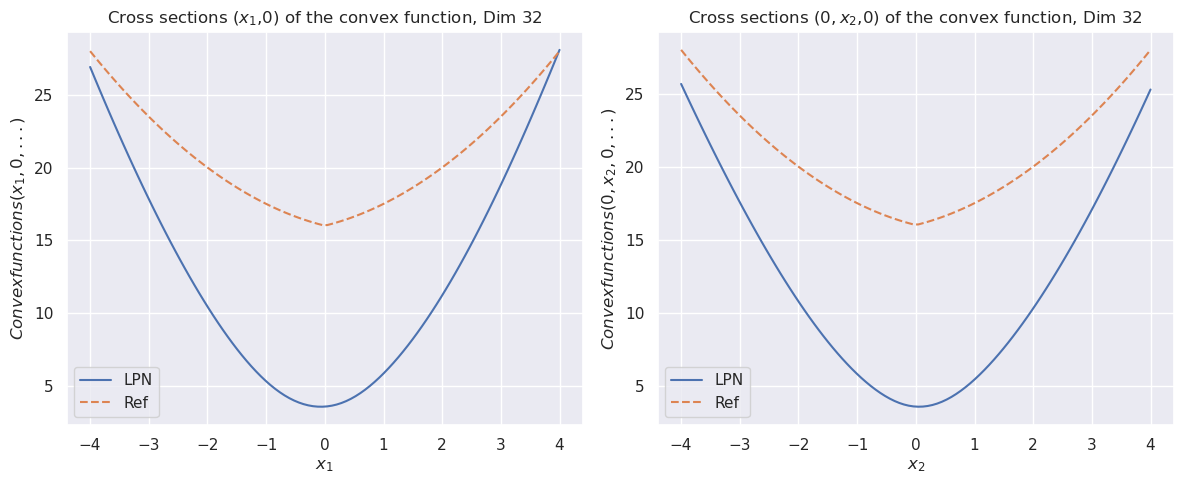

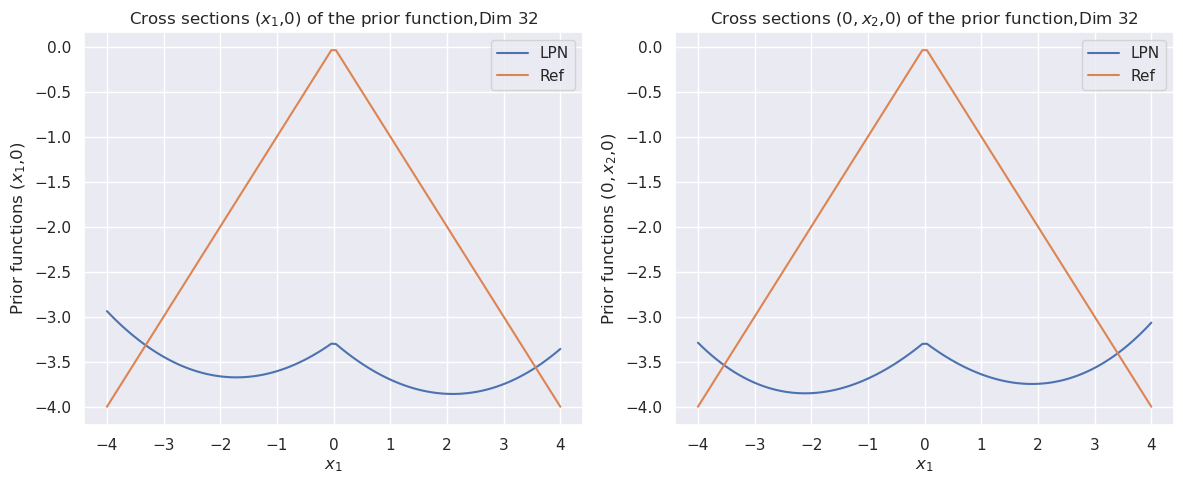

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 5032.93408203125
iteration 0 loss 626.64013671875


iteration 5000 loss 2.061155080795288


iteration 10000 loss 0.9304947257041931


iteration 15000 loss 0.6241810917854309


iteration 20000 loss 0.45813339948654175


iteration 25000 loss 0.41423359513282776


iteration 30000 loss 0.34043094515800476


iteration 35000 loss 0.4007672965526581


iteration 40000 loss 0.24427750706672668


iteration 45000 loss 0.46319714188575745


iteration 50000 loss 0.19655975699424744


iteration 55000 loss 0.1796228587627411


iteration 60000 loss 0.16890107095241547


iteration 65000 loss 0.15558229386806488


iteration 70000 loss 0.14168821275234222


iteration 75000 loss 1.626832127571106


iteration 80000 loss 0.12951640784740448


iteration 85000 loss 0.12045104801654816


iteration 90000 loss 0.12595491111278534


iteration 95000 loss 0.10558509081602097


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0973619669675827


iteration 105000 loss 0.09233500808477402


iteration 110000 loss 0.08677088469266891


iteration 115000 loss 0.08166754245758057


iteration 120000 loss 0.07738418132066727


iteration 125000 loss 0.0733492448925972


iteration 130000 loss 0.06979101151227951


iteration 135000 loss 0.06697151809930801


iteration 140000 loss 0.06420288234949112


iteration 145000 loss 0.06171794980764389


iteration 150000 loss 0.059451159089803696


iteration 155000 loss 0.05722656100988388


iteration 160000 loss 0.055280327796936035


iteration 165000 loss 0.05353836715221405


iteration 170000 loss 0.051620908081531525


iteration 175000 loss 0.04998647794127464


iteration 180000 loss 0.048500992357730865


iteration 185000 loss 0.04690835252404213


iteration 190000 loss 0.04579858109354973


iteration 195000 loss 0.04405910521745682


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.042765408754348755


iteration 205000 loss 0.042425014078617096


iteration 210000 loss 0.04122430086135864


iteration 215000 loss 0.03993602097034454


iteration 220000 loss 0.03873490169644356


iteration 225000 loss 0.03754578158259392


iteration 230000 loss 0.036458734422922134


iteration 235000 loss 0.035569049417972565


iteration 240000 loss 0.03453139588236809


iteration 245000 loss 0.03358633443713188


iteration 250000 loss 0.03268929943442345


iteration 255000 loss 0.031885776668787


iteration 260000 loss 0.03119080141186714


iteration 265000 loss 0.030375588685274124


iteration 270000 loss 0.029582951217889786


iteration 275000 loss 0.02883193828165531


iteration 280000 loss 0.02824588492512703


iteration 285000 loss 0.027692213654518127


iteration 290000 loss 0.027126934379339218


iteration 295000 loss 0.02652871049940586


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.025962859392166138


iteration 305000 loss 0.025863323360681534


iteration 310000 loss 0.025166789069771767


iteration 315000 loss 0.024291682988405228


iteration 320000 loss 0.023462584242224693


iteration 325000 loss 0.022674482315778732


iteration 330000 loss 0.021938398480415344


iteration 335000 loss 0.021238282322883606


iteration 340000 loss 0.020574914291501045


iteration 345000 loss 0.019945353269577026


iteration 350000 loss 0.019341927021741867


iteration 355000 loss 0.01876603625714779


iteration 360000 loss 0.018219931051135063


iteration 365000 loss 0.01770048215985298


iteration 370000 loss 0.017200853675603867


iteration 375000 loss 0.016728786751627922


iteration 380000 loss 0.01627880148589611


iteration 385000 loss 0.015849215909838676


iteration 390000 loss 0.015436452813446522


iteration 395000 loss 0.015037991106510162


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.01465847622603178


iteration 405000 loss 0.014580802991986275


iteration 410000 loss 0.014474809169769287


iteration 415000 loss 0.014373373240232468


iteration 420000 loss 0.014274705201387405


iteration 425000 loss 0.014178154990077019


iteration 430000 loss 0.0140834404155612


iteration 435000 loss 0.01399027369916439


iteration 440000 loss 0.013898493722081184


iteration 445000 loss 0.013807980343699455


iteration 450000 loss 0.013718575239181519


iteration 455000 loss 0.01363023929297924


iteration 460000 loss 0.01354295015335083


iteration 465000 loss 0.013456663116812706


iteration 470000 loss 0.013371270149946213


iteration 475000 loss 0.013286767527461052


iteration 480000 loss 0.013203100301325321


iteration 485000 loss 0.013120166957378387


iteration 490000 loss 0.013038009405136108


iteration 495000 loss 0.012956569902598858


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


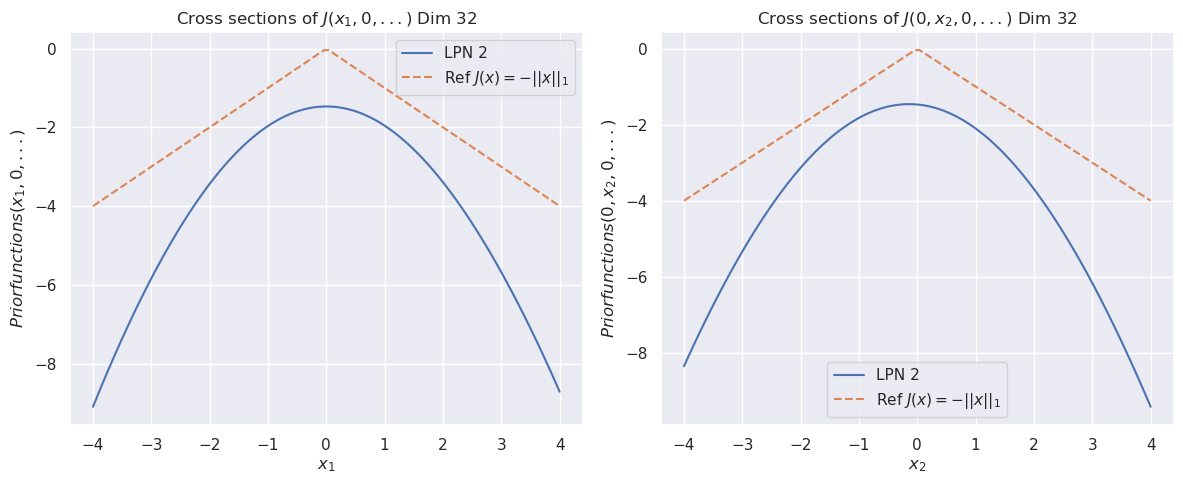

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)